# Hull Tactical Market Prediction

### Import Libralies

In [109]:
# Utilities
import os
from pathlib import Path
import pandas as pd
import numpy as np

# Visualization
from colorama import Fore, Style
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from dataclasses import dataclass, asdict

# Models
import lightgbm as lgb

# Submission
import polars as pl
import kaggle_evaluation.default_inference_server

In [110]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [111]:
INNER_VAL_LEN = 180
TRADING_DAYS_PER_YR = 252

### Definition

In [112]:
# ============ RETURNS TO SIGNAL CONFIGS ============
MIN_SIGNAL: float = 0.0                         # Minimum value for the daily signal 
MAX_SIGNAL: float = 2.0                         # Maximum value for the daily signal 
SIGNAL_MULTIPLIER: float = 7.5                 # Multiplier of the OLS market forward excess returns predictions to signal 

@dataclass(frozen=True)
class RetToSignalParameters:
    signal_multiplier: float 
    min_signal : float = MIN_SIGNAL
    max_signal : float = MAX_SIGNAL

ret_signal_params = RetToSignalParameters(
    signal_multiplier= SIGNAL_MULTIPLIER
)

def convert_ret_to_signal(
    ret_arr: np.ndarray,
    params: RetToSignalParameters,
    signal_multiplier=None
) -> np.ndarray:
    """
    Converts raw model predictions (expected returns) into a trading signal.

    Args:
        ret_arr (np.ndarray): The array of predicted returns.
        params (RetToSignalParameters): Parameters for scaling and clipping the signal.

    Returns:
        np.ndarray: The resulting trading signal, clipped between min and max values.
    """
    
    # 予測値を基準に，投資戦略シグナルに変換
    # ret * signal_multiplier + 1 を min_signal ~ max_signal の範囲にクリップ
    if signal_multiplier is None:
        multi = params.signal_multiplier    
    else:
        multi = signal_multiplier
    
    ret = np.clip(
        ret_arr * multi + 1,
        params.min_signal, 
        params.max_signal
    )

    if ret.size < 20:
        print(f"Strategy:")
        for i, value in enumerate(ret): print(f'  {i}: {value:.4f}')

    return ret

In [113]:
# convert_ret_to_signalの動作確認
# 20個の乱数(0~1)
hoge = convert_ret_to_signal(np.array([5, 0.1, 0.3, -0.2, 1.3]), ret_signal_params)

Strategy:
  0: 2.0000
  1: 1.7500
  2: 2.0000
  3: 0.0000
  4: 2.0000


In [114]:
# ============ LOAD DATA ============
# プラットフォームがkaggleかローカルかで分岐
if os.getenv('KAGGLE_KERNEL_RUN_TYPE') is not None:
    # Kaggle上
    DATA_PATH: Path = Path('/kaggle/input/hull-tactical-market-prediction/')
else:
    BASE_PATH = Path.cwd()
    DATA_PATH: Path = BASE_PATH / 'data'


train = pd.read_csv(DATA_PATH / "train.csv")
test = pd.read_csv(DATA_PATH / "test.csv")

### Scoreing

In [115]:
class ParticipantVisibleError(Exception):
    # Custom error to show messages to participants
    pass

def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, intermediate_res:list = []) -> float:
    """
    Calculates a custom evaluation metric (volatility-adjusted Sharpe ratio).

    This metric penalizes strategies that take on significantly more volatility
    than the underlying market.

    Returns:
        float: The calculated adjusted Sharpe ratio.
    """
    solution = solution.copy().reset_index(drop=True)
    submission = submission.copy().reset_index(drop=True)
    solution['position'] = submission['prediction']

    # ありえない値を除外する (0 <= position <= 2)
        # 0 means that we don't invest in S & P at all but get only the risk-free rate.
        # 1 means that we invest all our money in S & P.
        # 2 means that we invest twice our capital in S & P while taking a credit at the risk-free rate.
        # -> つまり，普通に預金するか，S&Pに投資するか，S&Pに2倍レバレッジで投資するか（借金）の割合
    if solution['position'].max() > MAX_SIGNAL:
        raise ParticipantVisibleError(f'Position of {solution["position"].max()} exceeds maximum of {MAX_SIGNAL}')
    if solution['position'].min() < MIN_SIGNAL:
        raise ParticipantVisibleError(f'Position of {solution["position"].min()} below minimum of {MIN_SIGNAL}')

    # Calculate strategy returns
    # フェデラルファンド金利(利息) * (1-予測値) + 予測値 * S&P500の翌日のリターン = 戦略のリターン(割合)
    solution['strategy_returns'] = solution['risk_free_rate'] * (1 - solution['position']) + solution['position'] * solution['forward_returns']

    # Calculate strategy's Sharpe ratio
    # リターンとその標準偏差を用いてシャープレシオ（リスクあたりの効率）を計算
    strategy_excess_returns = solution['strategy_returns'] - solution['risk_free_rate'] # 超過リターン -> 今回の戦略で得た割合から，リスクフリー時の割合を引いた分
    strategy_excess_cumulative = (1 + strategy_excess_returns).prod() # 累積超過リターン -> 全期間の超過リターンをかけ合わせた分(1+で倍率に変換)
    strategy_mean_excess_return = (strategy_excess_cumulative) ** (1 / len(solution)) - 1 # 平均超過リターン -> 複利は幾何平均で求める． また，倍率から割合に戻してる
    strategy_std = solution['strategy_returns'].std() # リターンの標準偏差

    trading_days_per_yr = 252 # 1年あたりの取引日数(固定値)
    if strategy_std == 0:
        raise ZeroDivisionError
    sharpe = strategy_mean_excess_return / strategy_std * np.sqrt(trading_days_per_yr) # 年率換算したシャープレシオ. sqrt(252)をかけることで年率換算している（統計的な性質らしい）
    strategy_volatility = float(strategy_std * np.sqrt(trading_days_per_yr) * 100)  # 年率換算したボラティリティ(価格変動率)

    # Calculate market return and volatility
    # S&P500に投資し続けた場合のリターンとボラティリティを計算
    market_excess_returns = solution['forward_returns'] - solution['risk_free_rate'] # S&P500が利息を上回る割合
    market_excess_cumulative = (1 + market_excess_returns).prod() # ↑の累積
    market_mean_excess_return = (market_excess_cumulative) ** (1 / len(solution)) - 1 # train: 0.0003066067595838273 幾何平均，割合化
    market_std = solution['forward_returns'].std() # S&P500のリターンの標準偏差
    
    market_volatility = float(market_std * np.sqrt(trading_days_per_yr) * 100) # train: 16.748459963166347 %
    
    # Calculate the volatility penalty
    # ボラティリティペナルティを計算
    # -> 市場のボラティリティの1.2倍を超える場合のペナルティ
    excess_vol = max(0, strategy_volatility / market_volatility - 1.2) if market_volatility > 0 else 0
    vol_penalty = 1 + excess_vol

    # Calculate the return penalty
    # リターンペナルティを計算
    # -> 市場のリターンを下回る場合のペナルティ
    return_gap = max(
        0,
        (market_mean_excess_return - strategy_mean_excess_return) * 100 * trading_days_per_yr,
    )
    return_penalty = 1 + (return_gap**2) / 100

    # Adjust the Sharpe ratio by the volatility and return penalty
    # ペナルティ値の反映
    adjusted_sharpe = sharpe / (vol_penalty * return_penalty)

    # print("strategy_excess_returns NaN数:", solution['strategy_returns'].isna().sum())
    # print("strategy_std:", strategy_std)
    # print("strategy_excess_cumulative:", strategy_excess_cumulative)
    # print("market_excess_cumulative:", market_excess_cumulative)
    # print("adjusted_sharpe:", adjusted_sharpe)
    try:
        intermediate_res.append((strategy_mean_excess_return, strategy_std, sharpe, vol_penalty, return_penalty)) # 各値を記録(debug)
        return min(float(adjusted_sharpe), 1_000_000), intermediate_res # float変換，上限100万
    except NameError:
        return min(float(adjusted_sharpe), 1_000_000) # float変換，上限100万

### Training

In [116]:
def _rolling_vol_no_leak(fr: pd.Series, window_size: int) -> np.ndarray:
    # 過去のみ参照（center=False）。窓不足の序盤は expanding std で埋める（未来は使わない）
    roll = fr.rolling(window=window_size, min_periods=window_size, center=False).std()
    # 序盤: 窓不足部分（NaN）を expanding std で補う（過去のみ）
    expd = fr.expanding(min_periods=2).std()  # 1点ではstdはNaNのまま
    vol = roll.combine_first(expd).bfill(limit=0)  # bfill(limit=0) 実質何もしない（安全のため残す）
    return vol.to_numpy()

def _ewma_vol_series(fr: pd.Series, lam: float = 0.94, min_periods: int = 2) -> np.ndarray:
    # EWMA分散 → 平方根でボラ。adjust=False で再帰形（オンライン更新と等価）
    var = (fr**2).ewm(alpha=1 - lam, adjust=False, min_periods=min_periods).mean()
    return np.sqrt(var).to_numpy()

def calculate_volatility_scaling_factor(
    y_pred: np.ndarray,
    solution: pd.DataFrame,
    window_size: int = 30,
    *,
    vol_mode: str = "ewma",         # "rolling" or "ewma"
    lambda_ewma: float = 0.94,
    k_grid: np.ndarray | None = None,
    alpha_grid: np.ndarray | None = None,
    eps: float = 1e-6,
    lambda_reg: float = 0.0
) -> tuple[float, float, float]:
    """
    ボラ依存スケーリング:
        m_t = k / (sigma_t + eps)^alpha
    を inner データ上で score() 最大化となる (k, alpha) を探索。

    Args:
        y_pred: inner 区間のモデル予測（len == len(solution)）
        solution: 'forward_returns', 'risk_free_rate' を持つ DataFrame（inner 区間）
        window_size: rolling 用の窓
        vol_mode: "rolling" or "ewma"
        lambda_ewma: EWMA の λ
        k_grid, alpha_grid: 探索グリッド（未指定なら内部既定）
        eps: ゼロ除算回避
        lambda_reg: L2 正則化強度

    Returns:
        best_k (float)     :  最適化された k の値
        best_alpha (float) :  最適化された α の値
        best_score (float) :  最適化されたときの報酬値
    """
    # 入力検証
    y_pred = np.asarray(y_pred).reshape(-1)
    if not {"forward_returns", "risk_free_rate"}.issubset(solution.columns):
        raise ValueError("solution must have columns: forward_returns, risk_free_rate")
    if len(y_pred) != len(solution):
        raise ValueError(f"Length mismatch: y_pred={len(y_pred)} vs solution={len(solution)}")

    fr = solution["forward_returns"]

    # ボラ計算
    if vol_mode == "rolling":
        market_vol = _rolling_vol_no_leak(fr, window_size=window_size)
    elif vol_mode == "ewma":
        market_vol = _ewma_vol_series(fr, lam=lambda_ewma, min_periods=max(2, int(window_size // 4)))
    else:
        raise ValueError("vol_mode must be 'rolling' or 'ewma'")

    # グリッド定義
    if k_grid is None:
        k_grid = np.logspace(-4, np.log10(1.0), 20)  # kの探索範囲:10^-4 ~ 1.0までを20ステップ
    if alpha_grid is None:
        alpha_grid = np.linspace(0, 1.0, 5)  # αの探索範囲とステップ


    best_score = -np.inf
    best_k = None
    best_alpha = None

    for k in k_grid:
        for alpha in alpha_grid:
            m_t = k / np.power(market_vol + eps, alpha)
            # 戦略(0-2)に変換：convert_ret_to_signal がベクトルmultiplier非対応なら、先に y_pred*m_t を計算して渡す
            alloc = convert_ret_to_signal(y_pred, ret_signal_params, signal_multiplier=m_t)
            sub = pd.DataFrame({"prediction": alloc}).reset_index(drop=True)
            s, _ = score(solution, sub, "", [])
            if lambda_reg > 0:
                s -= lambda_reg * (k**2 + alpha**2)
            if s > best_score:
                best_score, best_k, best_alpha = s, float(k), float(alpha)
                # print(f"New best score: {best_score:.6f} (k={best_k:.6f}, alpha={best_alpha:.6f})")

    return float(best_k), float(best_alpha), float(best_score)

In [117]:
def _make_sigma_for_period(fr_all: np.ndarray, start: int, end: int,
                           mode="ewma", lam=0.94, window=30) -> np.ndarray:
    """ [start, end) 用の σ_t を、直前の過去だけを使って作る（リークなし）。 """
    warm = max(window, 20)
    prefix_start = max(0, start - warm)
    fr_prefix = fr_all[prefix_start:start]
    fr_period  = fr_all[start:end]
    fr_concat  = np.concatenate([fr_prefix, fr_period])
    s = pd.Series(fr_concat)
    if mode == "rolling":
        sigma_all = _rolling_vol_no_leak(s, window_size=window)
    elif mode == "ewma":
        sigma_all = _ewma_vol_series(s, lam=lam, min_periods=max(2, window//4))
    else:
        raise ValueError("vol_mode must be 'rolling' or 'ewma'")
    return sigma_all[-(end - start):]  # 期間ぶんだけ取り出す

In [118]:
score_list_dict = {}
def cross_validate(allocation_model, label="", min_train_size=1500, test_size=180):
    """
    時系列を考慮した交差検証を行う
    検証インデックス：
    range(len(train) - test_size, min_train_size, - test_size)
    例えば、trainデータが2000行、test_size=120、min_train_size=1500の場合、
    検証用のインデックスは：
    range(2000 - 120, 1500, -120) = range(1880, 1500, -120)
    = (1880, 1760, 1640, 1520)
    となり、各foldで未来のデータを使用せずに評価することができる．
    trainサイズはfoldが進む毎に減少し，min_train_sizeに達したら終了する．
    減少させているのは未来リークを防ぐため．
    """
    n = len(train)
    oof = np.full(n, np.nan, dtype=float)
    score_list = []
    intermediate_res = []
    val_list = []

    # ===== 前処理（1回だけ） =====
    # 学習に使わない列を除いた特徴量列を一度だけ確定
    drop_cols = ["date_id", "forward_returns", "risk_free_rate", "market_forward_excess_returns"]
    feature_cols = [c for c in train.columns if c not in drop_cols]

    # 必要列を配列/ビューで保持（コピー最小化）
    X_all = train[feature_cols]                  # DataFrame（ループ内は iloc でビュー切り）
    y_all = train["forward_returns"].to_numpy()  # 1D ndarray
    rfr_all = train["risk_free_rate"].to_numpy() # 1D ndarray

    # バリデーション（固定で最後180）を一度だけ切り出し
    val_idx_start = max(0, n - 180)
    X_val = X_all.iloc[val_idx_start:]
    y_val = y_all[val_idx_start:]
    v_sol = pd.DataFrame(
        {
            "forward_returns": y_all[val_idx_start:],
            "risk_free_rate":  rfr_all[val_idx_start:],
        }
    ).reset_index(drop=True)

    for fold, test_start in enumerate(
        range(n - test_size, min_train_size, -test_size)
    ):
        print(Fore.CYAN + f"=== Fold {fold} Test start at {test_start} ===" + Style.RESET_ALL)
        # 1. データ分割（中間DataFrameを作らず直接切る）
        test_end = test_start + test_size

        X_train = X_all.iloc[:test_start]
        y_train = y_all[:test_start]

        X_test = X_all.iloc[test_start:test_end]
        y_test = y_all[test_start:test_end]  # 使わないが念のため残す（デバッグ等）
        
        # 評価用（score用のソリューション; 必要最小限のDF生成）
        solution = pd.DataFrame(
            {
                "forward_returns": y_all[test_start:test_end],
                "risk_free_rate":  rfr_all[test_start:test_end],
            }
        ).reset_index(drop=True)

        # 1.5. SIGNALE_MULTIPLIER の最適化
        # --- inner validation を train_fold の末尾から作る ---
        inner_start = max(0, test_start - INNER_VAL_LEN)
        X_inner = X_all.iloc[inner_start:test_start]
        y_inner = y_all[inner_start:test_start]
        sol_inner = pd.DataFrame({
            "forward_returns": y_all[inner_start:test_start],
            "risk_free_rate":  rfr_all[inner_start:test_start],
        }).reset_index(drop=True)

        # 2. モデル学習
        allocation_model.fit(X_train, y_train)

        # 2.5. inner validation で (k, alpha) を決定
        y_pred_inner = allocation_model.predict(X_inner)
        best_k, best_alpha, best_score = calculate_volatility_scaling_factor(y_pred_inner, sol_inner)

        # ===== テスト区間の m_t を “再計算” して適用（リークなし） =====
        # vol の作り方は calculate_volatility_scaling_factor と同じモード/パラメータに揃える
        VOL_MODE = "ewma"       # or "rolling"
        LAMBDA_EWMA = 0.94
        WINDOW_SIZE = 30
        EPS = 1e-6

        # 3. 予測
        y_pred = allocation_model.predict(X_test)

        # テスト用 σ_t と m_t（ベクトル）を作成
        sigma_test = _make_sigma_for_period(y_all, test_start, test_end,
                                            mode=VOL_MODE, lam=LAMBDA_EWMA, window=WINDOW_SIZE)
        m_t_test = best_k / np.power(sigma_test + EPS, best_alpha)
        # allocation_list = np.clip(y_pred, 0, 2)  # 投資比率は0から2の間にクリップ
        allocation_list = convert_ret_to_signal(y_pred, ret_signal_params, signal_multiplier=m_t_test)

        # 4. 評価
        submission = pd.DataFrame({"prediction": allocation_list}).reset_index(drop=True)
        validation_score, intermediate_res = score(
            solution, submission, "", intermediate_res
        )

        pred_val = allocation_model.predict(X_val)
        pred_val = allocation_model.predict(X_val)
        val_start = val_idx_start
        val_end   = n
        sigma_val = _make_sigma_for_period(y_all, val_start, val_end,
                                        mode=VOL_MODE, lam=LAMBDA_EWMA, window=WINDOW_SIZE)
        m_t_val = best_k / np.power(sigma_val + EPS, best_alpha)

        val_allocation_list = convert_ret_to_signal(pred_val, ret_signal_params, signal_multiplier=m_t_val)
        val_submission = pd.DataFrame({"prediction": val_allocation_list}).reset_index(drop=True)
        val_score, inter = score(
            v_sol, val_submission, "", intermediate_res
        )
        if inter:
            strat_mu, strat_std, sharpe, vol_pen, ret_pen = inter[-1]
            print(f"[last180] sharpe={sharpe:.3f} vol_pen={vol_pen:.2f} ret_pen={ret_pen:.2f}")
        lo = np.mean(val_allocation_list <= 0.0)
        hi = np.mean(val_allocation_list >= 2.0)
        print(f"[last180] clip@0={lo:.2%}, clip@2={hi:.2%}")
        
        vol_penalty = intermediate_res[-1][3]   # ボラティリティペナルティ
        return_penalty = intermediate_res[-1][4]# リターンペナルティ
        
        display(HTML(
            f"<p  style='color: orange'>"
            f"train(:{test_start:4}) test({test_start:4}:{test_end:4})<br>"
            f"val_score: {validation_score:6.3f} {vol_penalty=:.2f} {return_penalty=:.2f}<br>"
            f"score(submission) : {val_score}<br>"
            f"best_k={best_k:.3f}, best_alpha={best_alpha:.3f}, "
            f"mean(m_test)={float(np.mean(m_t_test)):.3f}, mean(m_val)={float(np.mean(m_t_val)):.3f}"
            f"</p>"
        ))
        
        oof[test_start:test_end] = allocation_list
        score_list.append(validation_score)
        val_list.append(val_score)

        # 最初のfold modelを保存しておく
        # if fold == 0:
        #     submit_model = allocation_model
        # else :
        #     break

    # ===== 集計表示 =====
    submit_model = allocation_model
    display(HTML('<h2 style="text-align:center;color:orange">======== Result ========</h2>'))
    avg_validation_score = float(np.nanmean(score_list)) if len(score_list) else np.nan
    print(f"{label} Average Validation Score: {avg_validation_score:.6f}")
    
    # 全体スコア（インデックス揃え）
    mask = np.isfinite(oof)
    if np.any(mask):
        solution_all = pd.DataFrame(
            {
                "forward_returns": y_all[mask],
                "risk_free_rate":  rfr_all[mask],
            }
        ).reset_index(drop=True)
        submission_all = pd.DataFrame({'prediction': oof[mask]}).reset_index(drop=True)
        overall_score, intermediate_res = score(solution_all, submission_all, '', intermediate_res)
        vol_penalty = intermediate_res[-1][3] if intermediate_res else np.nan
        return_penalty = intermediate_res[-1][4] if intermediate_res else np.nan
        print(f"{label} Overall Validation Score: {overall_score:.6f} vol_penalty={vol_penalty:.2f} return_penalty={return_penalty:.2f}")
    else:
        print(f"{label} Overall Validation Score: NaN (no valid OOF)")



    score_list_dict[label] = score_list
    # 1回目のfoldのスコアを示す
    if score_list:
        print(f"{label} First(Test) Fold Validation Score: {score_list[0]:.6f}")

    if val_list:
        print(Fore.YELLOW + f"All(Test) Fold Validation Score : {(sum(val_list) / len(val_list)):6.3f}" + Style.RESET_ALL)
        

    # 分布可視化
    vals = oof[mask]
    if len(vals):
        vmin, vmax = float(np.min(vals)), float(np.max(vals))
        if vmin == vmax:
            vmax = vmin + 1e-6
        bins = np.linspace(vmin, vmax, 50)
        plt.figure(figsize=(6, 2))
        plt.hist(vals, bins=bins, density=False, color='c', edgecolor='k', linewidth=0.5)
        plt.title(f'Allocation histogram of {label}')
        plt.gca().get_yaxis().set_visible(False)
        plt.xlim(vmin, vmax)
        plt.show()

    print(f"Range of predictions: [{vmin:.6f}, {vmax:.6f}]")
    
    # SIGNAL_MULTIPLIER の算出（元ロジック踏襲）
    # ※ oofの分布に依存するため、maskチェックを入れる
    if np.any(mask):
        span = min(MAX_SIGNAL - 1.0, 1.0 - MIN_SIGNAL)  # 0-2なら span=1.0
        q = np.percentile(np.abs(oof[mask]), 99)        # 上位1%に合わせる
        SIGNAL_MULTIPLIER = (0.95 * span) / max(q, 1e-12)
        print(f"multi::{SIGNAL_MULTIPLIER}")
    else:
        print("multi::NaN (no valid OOF)")
    

    return submit_model

=== Fold 0 Test start at 8810 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21575
[LightGBM] [Info] Number of data points in the train set: 8810, number of used features: 94
[LightGBM] [Info] Start training from score 0.000468
[last180] sharpe=0.349 vol_pen=1.12 ret_pen=1.00
[last180] clip@0=0.00%, clip@2=1.11%


=== Fold 1 Test start at 8630 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21573
[LightGBM] [Info] Number of data points in the train set: 8630, number of used features: 94
[LightGBM] [Info] Start training from score 0.000460
[last180] sharpe=0.134 vol_pen=1.08 ret_pen=1.25
[last180] clip@0=0.00%, clip@2=0.56%


=== Fold 2 Test start at 8450 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21575
[LightGBM] [Info] Number of data points in the train set: 8450, number of used features: 94
[LightGBM] [Info] Start training from score 0.000453
[last180] sharpe=0.283 vol_pen=1.06 ret_pen=1.03
[last180] clip@0=0.00%, clip@2=0.56%


=== Fold 3 Test start at 8270 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21574
[LightGBM] [Info] Number of data points in the train set: 8270, number of used features: 94
[LightGBM] [Info] Start training from score 0.000440
[last180] sharpe=0.527 vol_pen=1.02 ret_pen=1.00
[last180] clip@0=0.00%, clip@2=0.56%


=== Fold 4 Test start at 8090 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21569
[LightGBM] [Info] Number of data points in the train set: 8090, number of used features: 94
[LightGBM] [Info] Start training from score 0.000468
[last180] sharpe=0.262 vol_pen=1.06 ret_pen=1.05
[last180] clip@0=0.00%, clip@2=0.56%


=== Fold 5 Test start at 7910 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21568
[LightGBM] [Info] Number of data points in the train set: 7910, number of used features: 94
[LightGBM] [Info] Start training from score 0.000465
[last180] sharpe=0.368 vol_pen=1.09 ret_pen=1.00
[last180] clip@0=0.00%, clip@2=1.11%


=== Fold 6 Test start at 7730 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21566
[LightGBM] [Info] Number of data points in the train set: 7730, number of used features: 94
[LightGBM] [Info] Start training from score 0.000448
[last180] sharpe=0.307 vol_pen=1.01 ret_pen=1.02
[last180] clip@0=0.00%, clip@2=1.11%


=== Fold 7 Test start at 7550 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21508
[LightGBM] [Info] Number of data points in the train set: 7550, number of used features: 94
[LightGBM] [Info] Start training from score 0.000434
[last180] sharpe=0.423 vol_pen=1.04 ret_pen=1.00
[last180] clip@0=0.00%, clip@2=1.11%


=== Fold 8 Test start at 7370 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21444
[LightGBM] [Info] Number of data points in the train set: 7370, number of used features: 94
[LightGBM] [Info] Start training from score 0.000428
[last180] sharpe=0.353 vol_pen=1.07 ret_pen=1.00
[last180] clip@0=0.00%, clip@2=2.22%


=== Fold 9 Test start at 7190 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21383
[LightGBM] [Info] Number of data points in the train set: 7190, number of used features: 94
[LightGBM] [Info] Start training from score 0.000433
[last180] sharpe=0.126 vol_pen=1.21 ret_pen=1.24
[last180] clip@0=0.00%, clip@2=5.00%


=== Fold 10 Test start at 7010 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21328
[LightGBM] [Info] Number of data points in the train set: 7010, number of used features: 94
[LightGBM] [Info] Start training from score 0.000428
[last180] sharpe=0.404 vol_pen=1.11 ret_pen=1.00
[last180] clip@0=0.00%, clip@2=3.89%


=== Fold 11 Test start at 6830 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21313
[LightGBM] [Info] Number of data points in the train set: 6830, number of used features: 93
[LightGBM] [Info] Start training from score 0.000421
[last180] sharpe=0.355 vol_pen=1.19 ret_pen=1.00
[last180] clip@0=0.00%, clip@2=2.22%


=== Fold 12 Test start at 6650 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21261
[LightGBM] [Info] Number of data points in the train set: 6650, number of used features: 93
[LightGBM] [Info] Start training from score 0.000413
[last180] sharpe=0.229 vol_pen=1.25 ret_pen=1.05
[last180] clip@0=0.00%, clip@2=4.44%


=== Fold 13 Test start at 6470 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21194
[LightGBM] [Info] Number of data points in the train set: 6470, number of used features: 93
[LightGBM] [Info] Start training from score 0.000413
[last180] sharpe=0.263 vol_pen=1.08 ret_pen=1.05
[last180] clip@0=0.56%, clip@2=1.67%


=== Fold 14 Test start at 6290 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21072
[LightGBM] [Info] Number of data points in the train set: 6290, number of used features: 93
[LightGBM] [Info] Start training from score 0.000422
[last180] sharpe=0.377 vol_pen=1.23 ret_pen=1.00
[last180] clip@0=0.00%, clip@2=5.00%


=== Fold 15 Test start at 6110 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20660
[LightGBM] [Info] Number of data points in the train set: 6110, number of used features: 93
[LightGBM] [Info] Start training from score 0.000424
[last180] sharpe=0.150 vol_pen=1.15 ret_pen=1.20
[last180] clip@0=1.11%, clip@2=2.22%


=== Fold 16 Test start at 5930 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20389
[LightGBM] [Info] Number of data points in the train set: 5930, number of used features: 92
[LightGBM] [Info] Start training from score 0.000415
[last180] sharpe=0.423 vol_pen=1.00 ret_pen=1.00
[last180] clip@0=3.89%, clip@2=1.67%


=== Fold 17 Test start at 5750 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19944
[LightGBM] [Info] Number of data points in the train set: 5750, number of used features: 91
[LightGBM] [Info] Start training from score 0.000396
[last180] sharpe=0.329 vol_pen=1.02 ret_pen=1.01
[last180] clip@0=0.56%, clip@2=1.67%


=== Fold 18 Test start at 5570 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19631
[LightGBM] [Info] Number of data points in the train set: 5570, number of used features: 91
[LightGBM] [Info] Start training from score 0.000394
[last180] sharpe=0.694 vol_pen=1.12 ret_pen=1.00
[last180] clip@0=0.00%, clip@2=2.78%


=== Fold 19 Test start at 5390 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19296
[LightGBM] [Info] Number of data points in the train set: 5390, number of used features: 88
[LightGBM] [Info] Start training from score 0.000394
[last180] sharpe=0.121 vol_pen=1.00 ret_pen=1.30
[last180] clip@0=0.56%, clip@2=0.56%


=== Fold 20 Test start at 5210 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19172
[LightGBM] [Info] Number of data points in the train set: 5210, number of used features: 88
[LightGBM] [Info] Start training from score 0.000362
[last180] sharpe=-0.077 vol_pen=1.00 ret_pen=1.91
[last180] clip@0=12.78%, clip@2=1.67%


=== Fold 21 Test start at 5030 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19057
[LightGBM] [Info] Number of data points in the train set: 5030, number of used features: 87
[LightGBM] [Info] Start training from score 0.000377
[last180] sharpe=0.204 vol_pen=1.00 ret_pen=1.15
[last180] clip@0=0.56%, clip@2=1.67%


=== Fold 22 Test start at 4850 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18949
[LightGBM] [Info] Number of data points in the train set: 4850, number of used features: 87
[LightGBM] [Info] Start training from score 0.000312
[last180] sharpe=0.085 vol_pen=1.00 ret_pen=1.40
[last180] clip@0=21.11%, clip@2=1.11%


=== Fold 23 Test start at 4670 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18896
[LightGBM] [Info] Number of data points in the train set: 4670, number of used features: 87
[LightGBM] [Info] Start training from score 0.000386
[last180] sharpe=0.041 vol_pen=1.00 ret_pen=1.52
[last180] clip@0=16.67%, clip@2=1.67%


=== Fold 24 Test start at 4490 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18469
[LightGBM] [Info] Number of data points in the train set: 4490, number of used features: 86
[LightGBM] [Info] Start training from score 0.000442
[last180] sharpe=-0.057 vol_pen=1.01 ret_pen=1.84
[last180] clip@0=10.00%, clip@2=2.22%


=== Fold 25 Test start at 4310 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18318
[LightGBM] [Info] Number of data points in the train set: 4310, number of used features: 86
[LightGBM] [Info] Start training from score 0.000444
[last180] sharpe=0.254 vol_pen=1.09 ret_pen=1.05
[last180] clip@0=3.89%, clip@2=1.67%


=== Fold 26 Test start at 4130 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18264
[LightGBM] [Info] Number of data points in the train set: 4130, number of used features: 86
[LightGBM] [Info] Start training from score 0.000425
[last180] sharpe=-0.005 vol_pen=1.03 ret_pen=1.66
[last180] clip@0=2.78%, clip@2=1.67%


=== Fold 27 Test start at 3950 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17761
[LightGBM] [Info] Number of data points in the train set: 3950, number of used features: 86
[LightGBM] [Info] Start training from score 0.000430
[last180] sharpe=0.424 vol_pen=1.00 ret_pen=1.00
[last180] clip@0=6.11%, clip@2=2.22%


=== Fold 28 Test start at 3770 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17476
[LightGBM] [Info] Number of data points in the train set: 3770, number of used features: 86
[LightGBM] [Info] Start training from score 0.000444
[last180] sharpe=0.247 vol_pen=1.02 ret_pen=1.08
[last180] clip@0=6.67%, clip@2=1.67%


=== Fold 29 Test start at 3590 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17231
[LightGBM] [Info] Number of data points in the train set: 3590, number of used features: 86
[LightGBM] [Info] Start training from score 0.000440
[last180] sharpe=0.142 vol_pen=1.00 ret_pen=1.25
[last180] clip@0=5.56%, clip@2=1.67%


=== Fold 30 Test start at 3410 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17027
[LightGBM] [Info] Number of data points in the train set: 3410, number of used features: 85
[LightGBM] [Info] Start training from score 0.000425
[last180] sharpe=0.710 vol_pen=1.05 ret_pen=1.00
[last180] clip@0=9.44%, clip@2=2.78%


=== Fold 31 Test start at 3230 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16840
[LightGBM] [Info] Number of data points in the train set: 3230, number of used features: 83
[LightGBM] [Info] Start training from score 0.000411
[last180] sharpe=0.138 vol_pen=1.02 ret_pen=1.26
[last180] clip@0=14.44%, clip@2=1.67%


=== Fold 32 Test start at 3050 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16764
[LightGBM] [Info] Number of data points in the train set: 3050, number of used features: 83
[LightGBM] [Info] Start training from score 0.000508
[last180] sharpe=0.112 vol_pen=1.08 ret_pen=1.30
[last180] clip@0=4.44%, clip@2=1.11%


=== Fold 33 Test start at 2870 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16753
[LightGBM] [Info] Number of data points in the train set: 2870, number of used features: 82
[LightGBM] [Info] Start training from score 0.000571
[last180] sharpe=0.221 vol_pen=1.00 ret_pen=1.12
[last180] clip@0=11.11%, clip@2=0.00%


=== Fold 34 Test start at 2690 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16710
[LightGBM] [Info] Number of data points in the train set: 2690, number of used features: 82
[LightGBM] [Info] Start training from score 0.000672
[last180] sharpe=0.483 vol_pen=1.42 ret_pen=1.00
[last180] clip@0=1.11%, clip@2=5.56%


=== Fold 35 Test start at 2510 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16510
[LightGBM] [Info] Number of data points in the train set: 2510, number of used features: 82
[LightGBM] [Info] Start training from score 0.000688
[last180] sharpe=0.493 vol_pen=1.13 ret_pen=1.00
[last180] clip@0=0.56%, clip@2=1.11%


=== Fold 36 Test start at 2330 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16156
[LightGBM] [Info] Number of data points in the train set: 2330, number of used features: 82
[LightGBM] [Info] Start training from score 0.000685
[last180] sharpe=0.440 vol_pen=1.32 ret_pen=1.00
[last180] clip@0=0.00%, clip@2=3.33%


=== Fold 37 Test start at 2150 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14744
[LightGBM] [Info] Number of data points in the train set: 2150, number of used features: 82
[LightGBM] [Info] Start training from score 0.000685
[last180] sharpe=0.591 vol_pen=1.00 ret_pen=1.00
[last180] clip@0=3.33%, clip@2=0.00%


=== Fold 38 Test start at 1970 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13765
[LightGBM] [Info] Number of data points in the train set: 1970, number of used features: 81
[LightGBM] [Info] Start training from score 0.000635
[last180] sharpe=0.794 vol_pen=1.00 ret_pen=1.00
[last180] clip@0=7.22%, clip@2=2.22%


=== Fold 39 Test start at 1790 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13090
[LightGBM] [Info] Number of data points in the train set: 1790, number of used features: 80
[LightGBM] [Info] Start training from score 0.000562
[last180] sharpe=0.309 vol_pen=1.08 ret_pen=1.01
[last180] clip@0=0.00%, clip@2=0.00%


=== Fold 40 Test start at 1610 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10124
[LightGBM] [Info] Number of data points in the train set: 1610, number of used features: 77
[LightGBM] [Info] Start training from score 0.000519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

LightGBM Model Average Validation Score: 0.806738
LightGBM Model Overall Validation Score: 0.487837 vol_penalty=1.07 return_penalty=1.00
LightGBM Model First(Test) Fold Validation Score: 0.311591
All(Test) Fold Validation Score :  0.274


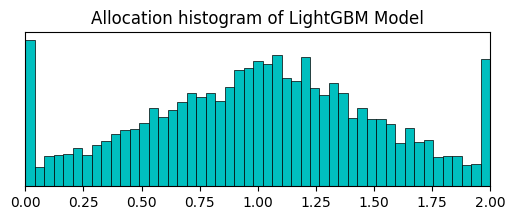

Range of predictions: [0.000000, 2.000000]
multi::0.475


In [119]:
# 単純なLightGBMモデルで試す

allocation_model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    colsample_bytree=0.8,
    subsample=0.8,
    random_state=42,
)

submit_model = cross_validate(allocation_model, label="LightGBM Model")

### Submission
- time-series streaming形式
- Kaggle サーバーから1batchずつ送られるデータからsubmission.parquetを返す
- 返り値検証があるため，指定された形式で返す
- 指定形式
  - 

In [120]:
def predict(test: pl.DataFrame) -> float:
    """Replace this function with your inference code."""
    test_pd = test.to_pandas()
    # display(test_pd.info())
    if len(test_pd.columns) > 94:
        test_pd = test_pd.drop(
            ["date_id", "is_scored", "lagged_forward_returns", "lagged_risk_free_rate", "lagged_market_forward_excess_returns"], 
            axis = 1)
    
    preds = submit_model.predict(test_pd)
    raw_pred: float = float(preds[0])
    print(f"predict:{raw_pred}")
    
    # --- 出力（float or ndarray）---
    # KaggleのAPI仕様上、float単体かSeries/DataFrameで返す必要あり float(preds[0]) if len(preds) == 1 else preds　
    return convert_ret_to_signal(raw_pred, ret_signal_params)

In [121]:
# サーバー上でpredict(test_batch)を動かす
inference_server = kaggle_evaluation.default_inference_server.DefaultInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(('/kaggle/input/hull-tactical-market-prediction/',))

GatewayRuntimeError: (<GatewayRuntimeErrorType.GATEWAY_RAISED_EXCEPTION: 5>, 'Traceback (most recent call last):\n  File "/home/masa1357/Dockerdata/kaggle/Kaggle_Hull-Tactical---Market-Prediction/kaggle_evaluation/core/base_gateway.py", line 134, in run\n    predictions, row_ids = self.get_all_predictions()\n  File "/home/masa1357/Dockerdata/kaggle/Kaggle_Hull-Tactical---Market-Prediction/kaggle_evaluation/core/base_gateway.py", line 109, in get_all_predictions\n    for data_batch, row_ids in self.generate_data_batches():\n  File "/home/masa1357/Dockerdata/kaggle/Kaggle_Hull-Tactical---Market-Prediction/kaggle_evaluation/default_gateway.py", line 29, in generate_data_batches\n    test = pl.read_csv(self.competition_data_dir / \'test.csv\')\n  File "/usr/local/lib/python3.10/dist-packages/polars/_utils/deprecation.py", line 128, in wrapper\n    return function(*args, **kwargs)\n  File "/usr/local/lib/python3.10/dist-packages/polars/_utils/deprecation.py", line 128, in wrapper\n    return function(*args, **kwargs)\n  File "/usr/local/lib/python3.10/dist-packages/polars/_utils/deprecation.py", line 128, in wrapper\n    return function(*args, **kwargs)\n  File "/usr/local/lib/python3.10/dist-packages/polars/io/csv/functions.py", line 549, in read_csv\n    df = _read_csv_impl(\n  File "/usr/local/lib/python3.10/dist-packages/polars/io/csv/functions.py", line 697, in _read_csv_impl\n    pydf = PyDataFrame.read_csv(\nFileNotFoundError: No such file or directory (os error 2): /kaggle/input/hull-tactical-market-prediction/test.csv\n')